# Infrastructure hands-on: Customize your computing environment

In this notebook we will go through some steps to create and customize computing environments on the JupyterLab platform dedicated to the [First Hackathon of AI_INFN](https://agenda.infn.it/event/43129/).

In particular you will learn:
 * how to create and install a custom environment using conda;
 * how to create and install a custom environment using apptainer;
 * how to create a custom environment running in Docker image.
 


## Introduction: the setup

The setup you are running on for this hackathon is based on a software stack combining:
 * [OpenStack](https://www.openstack.org/) (only at CNAF), creating Virtual Machines that can dynamically expand the resources made available through JupyterHub;
 * [Kubernetes](https://kubernetes.io/docs/concepts/overview/what-is-kubernetes/), defining a possibly multi-VM overlay and distributing the data through the multiple nodes via NFS;
 * [JupyterHub](https://z2jh.jupyter.org/en/stable/), defining the network and storage policy for the client applications an the authentication procedure (managed via OIDC tokens through https://iam-demo.cloud.cnaf.infn.it);
 * [JupyterLab](https://jupyter.org/), providing the web application you are interacting with
 * [Jupyter-Server-Proxy](https://github.com/jupyterhub/jupyter-server-proxy), enabling JupyterLab to define additional HTTP(s) services that can be run and exposed via the JupyterLab authentication.
 
When JupyterHub authenticates a user, it deploy a docker container (which must match some rather loose requirements in terms of software versions) and mounts persistent volumes for:
 * `private/` user data, readable and writable only for the logged-in user;
 * `shared/` user data, with read-and-write policies that can be defined by the JupyterHub administrator;
 * software, distributed through `/envs` (one day it will become based on cvmfs).
 
To you, as a developer, this means that you have three ways for matching software dependencies for your applications:
 * rely on existing software in the docker or in `/envs`;
 * have the software installed as user data (either private or shared);
 * rely (or customize) software in the docker image.
 
The order we used to list the options should be intended as defining priorities: 
 1. as long as you can rely on managed software environements, you should do that, 
 2. if you need custom environments that can be managed via conda, you should create your personal or project environment, 
 3. if conda cannot manage your dependencies, you can define your own docker image with (almost) complete freedom.
 
During the rest of the hackathon, you will use managed software environments that we prepared for you, making sure they can exploit the GPU resources properly and that they are compatible with the exercises and use cases we intend to propose. 

But now, before moving to machine learning, let's go quickly through the custmization options, to enhance your experience with the facilities made available by INFN DataCloud.



## Create a custom `conda` environment in `private/`.

Most of the usecases and examples we have prepared for the hackathon make use of relatively modern python versions (Python 3.10 or newer), but let's consider the case in which you have some old-dependencies that was not ported to Python 3.10, yet, and you need to run on Python 3.8.

You can create your custom environment, say `myenv`, in your `private` folder.

The command to run is 
```bash
conda create -yp /home/private/myenv python=3.8
```
where 
 - `-y` indicates to skip the request for confirmation which cannot be provided in the notebook interface (you can avoid it if running in a terminal)
 - `-p <path>` indicates that the environment is not a *named* environment managed centrally by conda, but it is a self-contained environment in a specified path.
 - `python=3.8` represents here the list of packages to install (in this case only one package with specified version)


In [1]:
%%bash

conda create -yp /home/private/myenv python=3.8

Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.9.2





## Package Plan ##

  environment location: /home/private/myenv

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            2_gnu          23 KB  conda-forge
    bzip2-1.0.8                |       h4bc722e_7         247 KB  conda-forge
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    ld_impl_linux-64-2.43      |       h712a8e2_2         654 KB  conda-forge
    libffi-3.4.2               |       h7f98852_5          57 KB  conda-forge
    libgcc-14.2.0              |       h77fa898_1         829 KB  conda-forge
    libgcc-ng-14.2.0           |       h69a702a_1          53 KB  conda-forge
    libgomp-14.2.0             |       h77fa898_1         450 KB  conda-forge
    libnsl-2.0.1               |       hd590

Then you can popolate it with your dependencies, for example, let's install *TensorFlow* and *TensorBoard*.

Now, we will give for granted you know what *TensorFlow* is, but let's spend two lines on [TensorBoard](https://www.tensorflow.org/tensorboard).

TensorBoard is a web-based application to visualize TensorFlow operations, including metrics, losses, histograms... 

It is a much appreciated software profiling and debugging tool that we are considering here to make an example of a web-based application served through JupyterLab proxy.

> **Note.** Make sure the package `ipykernel` is also installed to enable using this kernel from Jupyter.

In [2]:
%%bash

conda run -p /home/private/myenv \
    pip install --root-user-action=ignore -q tensorflow tensorboard ipykernel

## Install the kernel in user space

If you want to use the new environment in the Jupyter notebooks, you must install its kernel in Jupyter. 
Installing a kernel is trivial, just activate the kernel and execute 
```bash
python3 -m ipykernel install --user --name "py38" --display-name "Python 3.8"
```

The `--user` flag indicates you are installing in a directory in your home, which is persistent.
The command would work also without `--user` as you are an administrator of your container. However, the kernel would be installed in a temporary directory in the ephemeral container file system. This may be intended if you are performing a quick test, but usually you want your environment to be persistent.

In order to manage the kernels in your user space, you may want to take a look to the directory `/home/private/.local/share/jupyter/kernels/`.
You can delete folders there to remove kernels from your dashboard or edit the `kernel.json` files to modify the behaviour of your kernels.


In [3]:
%%bash
conda run -p /home/private/myenv \
    python3 -m ipykernel install --user --name "py38" --display-name "Python 3.8"

find /home/private/.local/share/jupyter/kernels/

Installed kernelspec py38 in /home/private/.local/share/jupyter/kernels/py38

/home/private/.local/share/jupyter/kernels/
/home/private/.local/share/jupyter/kernels/alma9
/home/private/.local/share/jupyter/kernels/alma9/kernel.json
/home/private/.local/share/jupyter/kernels/py38
/home/private/.local/share/jupyter/kernels/py38/logo-32x32.png
/home/private/.local/share/jupyter/kernels/py38/logo-64x64.png
/home/private/.local/share/jupyter/kernels/py38/logo-svg.svg
/home/private/.local/share/jupyter/kernels/py38/kernel.json


## Use your custom kernel
Click on the right-top menu where the current kernel is indicated and pick your brand new kernel.

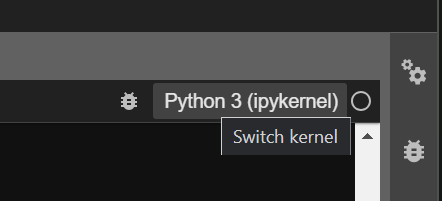

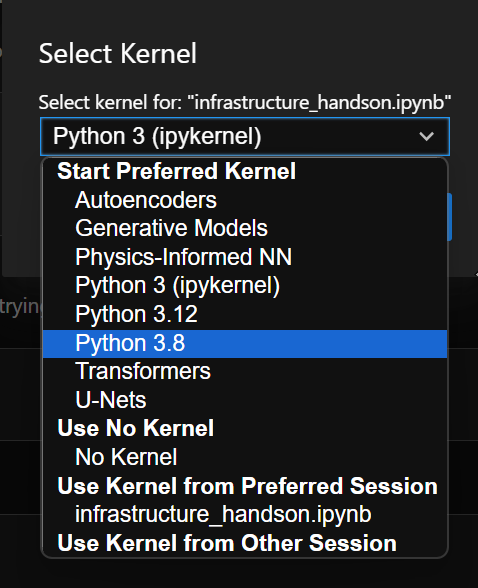

Congratulations, you have installed Python 3.8 and tensorflow in your user area.

> **Notice!** Don't expect GPU to be found properly. That requires some magic and that's why we have managed environments for the exercies.


You may verify the python version with `sys.version`.

In [1]:
import sys
sys.version

'3.8.20 | packaged by conda-forge | (default, Sep 30 2024, 17:52:49) \n[GCC 13.3.0]'

In [2]:
import tensorflow as tf
tf.__file__

2024-11-19 15:02:46.435519: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-19 15:02:47.695872: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-19 15:02:47.701249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 15:02:49.705206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'/home/private/myenv/lib/python3.8/site-packages/tensorflow/__init__.py'

You can also load the *TensorBoard* extension that you have installed.

In [3]:
%load_ext tensorboard

Then to execute the TensorBoard service through the Jupyter Server Proxy you need set the environmental variable `TENSORBOARD_PROXY_URL` to `/user/<your-username>/proxy/6006/` (the training `/` is important!).

For example,
```python
import os
os.environ['TENSORBOARD_PROXY_URL'] = "/user/%(JUPYTERHUB_USER)s/proxy/6006/" % os.environ
```

Once that is done, you can run TensorBoard easily either in the a cell of your notebook or accessing the address  https://hackathon.ai.cloud.infn.it/hub/user-redirect/proxy/6006/ (again, trailing `/` is important).

In [4]:
import os
os.environ['TENSORBOARD_PROXY_URL'] = "/user/%(JUPYTERHUB_USER)s/proxy/6006/" % os.environ
os.environ['TENSORBOARD_BINARY'] = "/home/private/myenv/bin/tensorboard"
%tensorboard --logdir /tmp/logs

# Create a custom environment using Podman

Conda is a very powerful tool, but sometimes it can be uneasy to export and reuse elsewhere a conda environment. 
Indeed, conda includes in the environment only the libraries and the packages that are strictly needed to run the installed packages, relying on the operating system for all the rest.

Containerization is a technique to embed a computing environment in a container, that can then be easily distributed and shipped around, together with your code.

Let's create a containerized environment to see how it looks like. 

To play with containers we will use `podman`. You need to install it in your container as it is not available per default.

```bash
apt install podman
```

We should also create a dedicated directory for our experiments. For example `/tmp/context`.


In [6]:
%%bash
apt-get -q update && apt-get install -qy podman

mkdir -p /tmp/context

Ign:1 http://cvmrepo.s3.cern.ch/cvmrepo/apt jammy-prod InRelease
Hit:2 http://cvmrepo.s3.cern.ch/cvmrepo/apt jammy-prod Release
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/apptainer/ppa/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,439 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,453 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [45.2 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,223 kB]
Fetched 5,417 kB in 2s (3,331 kB/s)
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
The following additional pack

debconf: delaying package configuration, since apt-utils is not installed


Fetched 27.6 MB in 2s (15.9 MB/s)
Selecting previously unselected package libmnl0:amd64.
(Reading database ... 135529 files and directories currently installed.)
Preparing to unpack .../00-libmnl0_1.0.4-3build2_amd64.deb ...
Unpacking libmnl0:amd64 (1.0.4-3build2) ...
Selecting previously unselected package libxtables12:amd64.
Preparing to unpack .../01-libxtables12_1.8.7-1ubuntu5.2_amd64.deb ...
Unpacking libxtables12:amd64 (1.8.7-1ubuntu5.2) ...
Selecting previously unselected package netbase.
Preparing to unpack .../02-netbase_6.3_all.deb ...
Unpacking netbase (6.3) ...
Selecting previously unselected package libip6tc2:amd64.
Preparing to unpack .../03-libip6tc2_1.8.7-1ubuntu5.2_amd64.deb ...
Unpacking libip6tc2:amd64 (1.8.7-1ubuntu5.2) ...
Selecting previously unselected package libnfnetlink0:amd64.
Preparing to unpack .../04-libnfnetlink0_1.0.1-3build3_amd64.deb ...
Unpacking libnfnetlink0:amd64 (1.0.1-3build3) ...
Selecting previously unselected package libnetfilter-conntrack3:am

Then we create a Docker file defining the contents of our container.

Create a filename named `Dockerfile.alma9` and insert the following commands:
 * We start from a generic container for an AlmaLinux9 distribution (the same used by the Worldwide Computing Grid and by CERN)
   ```dockerfile
   FROM registry-1.docker.io/almalinux/9-base:latest` 
   ```
   where `registry-1.docker.io` is simply a reference to DockerHub, which is not a default for podman (but it is for example for Docker).
   You can (and usually should) review the image you download from DockerHub starting from [their docs in DockerHub](https://hub.docker.com/r/almalinux/9-base).
 * Then we install python
   ```dockerfile
   RUN dnf update && dnf install -y python python-pip
   ```
 * And finally we install some python packages
   ```dockerfile
   RUN python -m pip install scikit-learn ipykernel
   ```
   Please **make sure you install `ipykernel`** which is responsible for creating the communication layer between Jupyter and the python installation.
   



In [7]:
%%writefile /tmp/context/Dockerfile.alma9

FROM registry-1.docker.io/almalinux/9-base:latest
RUN dnf update && dnf install -y python python-pip
RUN python -m pip install scikit-learn ipykernel


Writing /tmp/context/Dockerfile.alma9


In [8]:
%%bash

podman build /tmp/context/ -f /tmp/context/Dockerfile.alma9 -t myalma9:test

STEP 1/3: FROM registry-1.docker.io/almalinux/9-base:latest


Trying to pull registry-1.docker.io/almalinux/9-base:latest...
Getting image source signatures
Copying blob sha256:9215f449d8afb6720064720d0a0bb88fee43c12adbd5772bb893421e6244cd77
Copying blob sha256:9215f449d8afb6720064720d0a0bb88fee43c12adbd5772bb893421e6244cd77
Copying config sha256:ea5f74b66bbf0b16b7897cda591bdcbdf503068ae7e750bb25a220410482948e
Writing manifest to image destination
Storing signatures


STEP 2/3: RUN dnf update && dnf install -y python python-pip
AlmaLinux 9 - AppStream                          15 MB/s | 8.2 MB     00:00    
AlmaLinux 9 - BaseOS                            4.7 MB/s | 2.3 MB     00:00    
AlmaLinux 9 - Extras                             31 kB/s |  13 kB     00:00    
Dependencies resolved.
Nothing to do.
Complete!
Last metadata expiration check: 0:00:01 ago on Tue Nov 19 15:04:48 2024.
Dependencies resolved.
 Package                       Arch      Version             Repository    Size
Installing:
 python-unversioned-command    noarch    3.9.19-8.el9_5.1    appstream    9.0 k
 python3-pip                   noarch    21.3.1-1.el9        appstream    1.7 M
Installing weak dependencies:
 libxcrypt-compat              x86_64    4.4.18-3.el9        appstream     88 k
 python3-setuptools            noarch    53.0.0-13.el9       baseos       838 k

Transaction Summary
Install  4 Packages

Total download size: 2.7 M
Installed size: 13 M
(1/4): libxcrypt-compat

COMMIT myalma9:test
--> 4462a1858af
Successfully tagged localhost/myalma9:test
4462a1858afcbbdb9e23fc04945b6dbbf40edbc76ce6238ae9bee35e0b2adb8e


Test your installation by running simple command-line tests. Here:
 - `podman run` indicates we are starting a new container
 - `myalma9:test` is the image name, the one we have defined above
 - `python3 -c "..."` is a command that we will be running inside the container

In [9]:
%%bash
podman run myalma9:test python3 -c "import sys; print(sys.version)"
podman run myalma9:test python3 -c "import sklearn; print('scikit-learn version:', sklearn.__version__)"

3.9.19 (main, Sep 11 2024, 00:00:00) 
[GCC 11.5.0 20240719 (Red Hat 11.5.0-2)]
scikit-learn version: 1.5.2


One you are happy with your container, you should install it.
Here we do it manually, but be aware you can automate it in a number of ways (*e.g.* using [Dockernel](https://github.com/MrMino/dockernel)).

Create a new directory in the kernels area.

In [10]:
%%bash
mkdir -p /home/private/.local/share/jupyter/kernels/alma9

Create a the kernel definition file.

Since json does not allow comments we will comment it line by line here:
```json
{
    # `display_name` is the name of the kernel that you will find in the Jupyter Launcher
    # or in the drop-down menu in top-right corner of your notebooks.
    "display_name": "Alma9 in Podman",
    # argv is the list of arguments to pass to the launcher command. 
    # In practice it should be the command used to launch ipykernel_launcher split at spaces.
    "argv": [
        # The first line is the executable: podman in our case
        "/usr/bin/podman",
        # run is the first argument to the podman CLI, used to execute a custom command in the podmand container
        "run",
        # "--network host" indicates that podman should not use a network namespace but relying on the network of the 
        # main container. This is necessary to enable Jupyter connecting to the kernel via the container network.
        "--network",
        "host",
        # -v /home:/home maps the whole /home directory to the container, in read-write mode. 
        # The application in the container will transparently access to all of our data (you should trust the image)
        "-v",
        "/home:/home",
        # the following string indicates the name of the image we have built in the previous step
        "myalma9:test",
        # "python -m ipykernel_launcher -f {connection_file}" is the command to run to execute the kernel
        "python",
        "-m",
        "ipykernel_launcher",
        "-f",
        "{connection_file}"
    ],
    "language": "python",
    "metadata": {
        "debugger": true
    }
}
```



In [11]:
%%writefile /home/private/.local/share/jupyter/kernels/alma9/kernel.json
{
    "display_name": "Alma9 in Podman",
    "argv": [
        "/usr/bin/podman",
        "run",
        "--network",
        "host",
        "-v",
        "/home:/home",
        "myalma9:test",
        "python",
        "-m",
        "ipykernel_launcher",
        "-f",
        "{connection_file}"
    ],
    "language": "python",
    "metadata": {
        "debugger": true
    }
}


Overwriting /home/private/.local/share/jupyter/kernels/alma9/kernel.json


After a short delay (less than a minute) you should be able to pick the new kernel from the drop-down menu in the top-right corner.
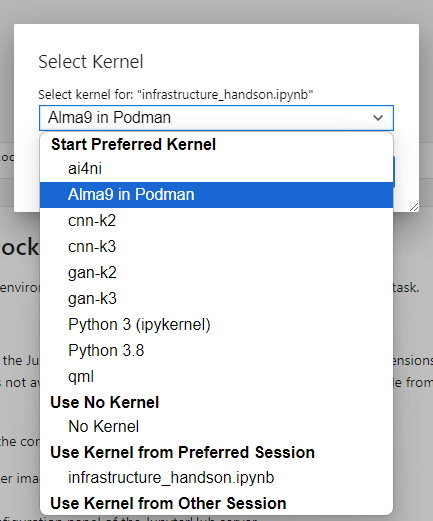

If you now print `sys.version` you will see you are running the system-level python of a RedHat-like distribution (Alma9)

In [1]:
import sys
print (sys.version)

3.9.19 (main, Sep 11 2024, 00:00:00) 
[GCC 11.5.0 20240719 (Red Hat 11.5.0-2)]


## Note: the preferred way of creating containers is Apptainer

For this hackathon, we decided to show you how to create and deploy a container using Podman. 
This allows building images from `Dockerfile`s which are widely used and most of you probably already know.
It is also the same technology used to replace the default container as we will see in a minute and so it is worth introducing it while avoiding spending time on the syntax of definition files for other systems. 

Nontheless, please note that the recommended way to define containerized Jupyter kernels is using apptainer.
Apptainer is pre-installed in the default images and can be used to define custom computing environments, with a lighter overhead.
In addition, apptainer images are contained in single files that can be easily distributed through multiple sites (which may mean the platform and your laptop) and can be run almost everywhere from Windows laptops to HPC centers.

An example of how to use Apptainer to create jupyter kernels is available in the [AI_INFN documentation](https://ai-infn.baltig-pages.infn.it/wp-1/docs/environments/apptainer/#apptainer-kernel-from-a-conda-environment).


## Create a custom Docker environment

Before you continue, **make sure you are running the main kernel of your container**

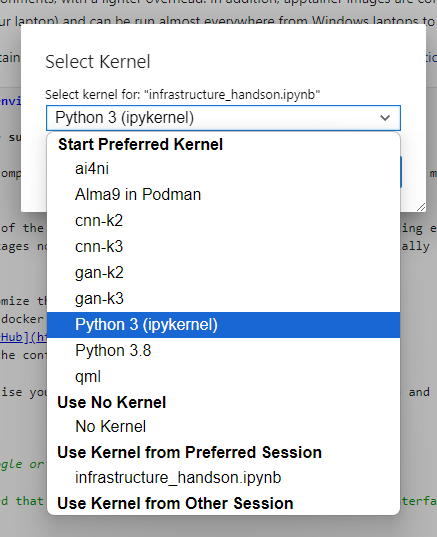


In some cases, creating a compute environment (with either conda, podman or apptainer) may not be sufficient to accomplish some specific task.

For example,
 * permanent configuration of the JupyterLab environment, developping or simply adding extensions;
 * installing software packages not available through the conda channels, but trivially installable from a package manager;
 * ... 
 
In this cases you can customize the computing environment by:
 1. creating your personal docker image;
 2. uploading it to [DockerHub](https://hub.docker.com);
 3. retrieving it through the configuration panel of the JupyterHub server. 
 
To continue with this exercise you will need an account on DockerHub, which is free and can be obtained [here](https://hub.docker.com/signup)

Once you have an account, you should associate your *podman* command line to DockerHub by typing `podman login registry-1.docker.io` in a terminal.

Instead of using your main password, it is recommended to use a token generated on purpose for the exercise.
Through your browser go to [DockerHub](https://hub.docker.com), then:
 * click on your Avatar in the top-right corner
 * pick "Account settings"
 * then "Personal Access Tokens"
 * click on the blue button "Generate new token"
 * Configure your new token with **Read & Write** permissions
   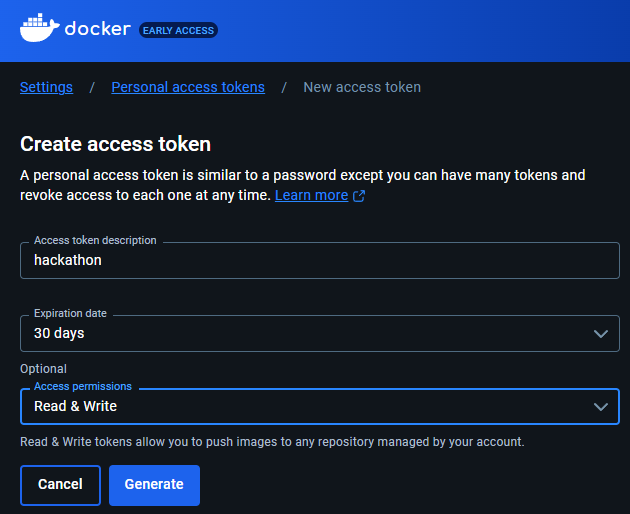
 * copy and paste in a secure place and then in the field below the generated token
   
In IPython you can do the following.

In [2]:
from getpass import getpass
username = input("Username:")
password = getpass("Password:")
!podman login registry-1.docker.io --username {username} --password {password}

Username: landerlini
Password: ········


Login Succeeded!


### Create Dockerfile

Now you can proceed with the definition of a custom docker image. 
For example, let's try to add a VS Code launcher to the JupyterLab dashboard, opening a remote instance of VS code in a new browser tab.

Create a file named, for example, `Dockerfile.vscode`. 

Inherit the Docker image from the default image for the JupyterHub environment you are using (for the hackathon, `landerlini/jhub-ai-infn:padova`), 
```Dockerfile
FROM registry-1.docker.io/landerlini/jhub-ai-infn:padova
```

And then edit the image as you wish, for example you can install packages from ubuntu repositories
```Dockerfile
RUN apt-get update && apt-get install --yes cowsay
```
Note the `--yes` flag indicating that the installation should assume consensus from you without asking. 

For running the installation script for [code-server, a browser-based distribution of VS code](https://github.com/coder/code-server) the [docs suggest](https://github.com/coder/code-server#getting-started) the following command: 
```bash
curl -fsSL https://code-server.dev/install.sh | sh
```

Hence, in our Dockerfile we will have:
```Dockerfile
RUN curl -fsSL https://code-server.dev/install.sh | sh
```

Finally, to add a nice launcher to the JupyterLab GUI, we need to install a three-file Python package, distributed through [GitHub](https://github.com/landerlini/jupyter_codeserver_proxy).
```Dockerfile
RUN pip install git+https://github.com/landerlini/jupyter_codeserver_proxy.git
```

---
To summarize, in this small example you have seen how to:
 * install packages from ubuntu repositories;
 * install software through installation scripts;
 * install Python package through pip.

---
Here is the Dockerfile we built together:

In [2]:
%%writefile /tmp/context/Dockerfile.vscode

FROM registry-1.docker.io/landerlini/jhub-ai-infn:padova

RUN apt-get update && apt-get install -y cowsay

RUN curl -fsSL https://code-server.dev/install.sh | sh

RUN pip install git+https://github.com/landerlini/jupyter_codeserver_proxy.git

Writing /tmp/context/Dockerfile.vscode


Let's build our image using 
```bash
podman build -t <complete_name_of_the_image_on_DockerHub> -f <input_docker_file> .
```

> **Notice!** The trailing dot is important.

The name you choose for your new docker image should begin with `<your-username>/` and end with `:<version-tag>`.

This is mandatory:
 * you are only allowed to upload images in your userspace in DockerHub, so uploading would fail if your image name does not begin with your username;
 * images must have a version tag, it can be basically whatever string, but you need to provide one.
 
 

My username in DockerHub is `landerlini`, and this is the first version of this docker image, so I will call my image
`landerlini/jhub_vscode:v1`.

**Please note that building this docker image is an heavy task that may require 5-10 minutes.**

In [3]:
%%bash

podman build -t landerlini/jhub_vscode:v1 -f /tmp/context/Dockerfile.vscode /tmp/context

STEP 1/4: FROM registry-1.docker.io/landerlini/jhub-ai-infn:padova


Trying to pull registry-1.docker.io/landerlini/jhub-ai-infn:padova...
Getting image source signatures
Copying blob sha256:77e45ee945dc8a1ce57be013482750833e7721903814e42510a3db2a05940aee
Copying blob sha256:aece8493d3972efa43bfd4ee3cdba659c0f787f8f59c82fb3e48c87cbb22a12e
Copying blob sha256:088f11eb1e74ae07b0c0cfefb7906e1821c0b84f00524cc8e4011c276fe7d2d7
Copying blob sha256:4f4fb700ef54461cfa02571ae0db9a0dc1e0cdb5577484a6d75e68dc38e8acc1
Copying blob sha256:ef8373d600b0ac4a916da50b72cb116efc56800836a264d1dd8ea8e07e76256d
Copying blob sha256:fd92c719666cac5862b8ea1e034eeb038c7191d52d0ff468c0a90ed68c0420a4
Copying blob sha256:aece8493d3972efa43bfd4ee3cdba659c0f787f8f59c82fb3e48c87cbb22a12e
Copying blob sha256:ef8373d600b0ac4a916da50b72cb116efc56800836a264d1dd8ea8e07e76256d
Copying blob sha256:77e45ee945dc8a1ce57be013482750833e7721903814e42510a3db2a05940aee
Copying blob sha256:a30f89a0af6c7f64872ff93f4a9445b9d25f1206982670a911b2c83b672f443a
Copying blob sha256:fd92c719666cac5862b8ea1e034e

STEP 2/4: RUN apt-get update && apt-get install -y cowsay
Ign:1 http://cvmrepo.s3.cern.ch/cvmrepo/apt jammy-prod InRelease
Hit:2 http://cvmrepo.s3.cern.ch/cvmrepo/apt jammy-prod Release
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/apptainer/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,223 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,453 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,439 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [45.2 kB]
Fetched 5,417 kB in 1s (6,352 kB/s)
Reading package lists...
Reading package lists...
Building dependency tree...


debconf: delaying package configuration, since apt-utils is not installed


Fetched 28.7 kB in 0s (76.9 kB/s)
Selecting previously unselected package libtext-charwidth-perl.
(Reading database ... 135529 files and directories currently installed.)
Preparing to unpack .../libtext-charwidth-perl_0.04-10build3_amd64.deb ...
Unpacking libtext-charwidth-perl (0.04-10build3) ...
Selecting previously unselected package cowsay.
Preparing to unpack .../cowsay_3.03+dfsg2-8_all.deb ...
Unpacking cowsay (3.03+dfsg2-8) ...
Setting up libtext-charwidth-perl (0.04-10build3) ...
Setting up cowsay (3.03+dfsg2-8) ...


time="2024-11-19T15:15:54Z" level=warning msg="SHELL is not supported for OCI image format, [/bin/bash -o pipefail -c] will be ignored. Must use `docker` format"


--> 79fd8233582
STEP 3/4: RUN curl -fsSL https://code-server.dev/install.sh | sh
Ubuntu 22.04.3 LTS
Installing v4.95.3 of the amd64 deb package from GitHub.

+ mkdir -p ~/.cache/code-server
+ curl -#fL -o ~/.cache/code-server/code-server_4.95.3_amd64.deb.incomplete -C - https://github.com/coder/code-server/releases/download/v4.95.3/code-server_4.95.3_amd64.deb


######################################################################## 100.0%


+ mv ~/.cache/code-server/code-server_4.95.3_amd64.deb.incomplete ~/.cache/code-server/code-server_4.95.3_amd64.deb
+ dpkg -i ~/.cache/code-server/code-server_4.95.3_amd64.deb
Selecting previously unselected package code-server.
(Reading database ... 135599 files and directories currently installed.)
Preparing to unpack .../code-server_4.95.3_amd64.deb ...
Unpacking code-server (4.95.3) ...
Setting up code-server (4.95.3) ...

deb package has been installed.

To have systemd start code-server now and restart on boot:
  sudo systemctl enable --now code-server@$USER
Or, if you don't want/need a background service you can run:
  code-server

Deploy code-server for your team with Coder: https://github.com/coder/coder


time="2024-11-19T15:17:01Z" level=warning msg="SHELL is not supported for OCI image format, [/bin/bash -o pipefail -c] will be ignored. Must use `docker` format"


--> 12aea74018b
STEP 4/4: RUN pip install git+https://github.com/landerlini/jupyter_codeserver_proxy.git
  Cloning https://github.com/landerlini/jupyter_codeserver_proxy.git to /tmp/pip-req-build-tfhlpvx5


  Running command git clone --filter=blob:none --quiet https://github.com/landerlini/jupyter_codeserver_proxy.git /tmp/pip-req-build-tfhlpvx5


  Resolved https://github.com/landerlini/jupyter_codeserver_proxy.git to commit c6b2d6f16774bbde18a52160cee11ec569436e64
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for jupyter-codeserver-proxy: filename=jupyter_codeserver_proxy-1.0b3-py3-none-any.whl size=26091 sha256=a563f1a1d00b32694f0d37fff7ca2acda2d1b2069b7777251b00af9c87ef537f
  Stored in directory: /tmp/pip-ephem-wheel-cache-md61ix8e/wheels/90/df/26/c19cb591199c49be5de687aa845de39d6b241f2f13aad779ab
Successfully built jupyter-codeserver-proxy


COMMIT landerlini/jhub_vscode:v1


time="2024-11-19T15:18:16Z" level=warning msg="SHELL is not supported for OCI image format, [/bin/bash -o pipefail -c] will be ignored. Must use `docker` format"


--> a737caccfc3
Successfully tagged localhost/landerlini/jhub_vscode:v1
a737caccfc39f13d549f0f409ce2fb729e53d04b0d9410e86662a7d25716500e


You can now list the docker images in your local system by typing a terminal 
```bash
podman image list
```

You should see your image appearing in the list. For example,
```
REPOSITORY                  TAG       IMAGE ID       CREATED          SIZE
landerlini/jhub_vscode      v1        bcad8ff4e4cc   47 minutes ago   6GB
```

In [4]:
%%bash 
podman image list

REPOSITORY                                    TAG         IMAGE ID      CREATED             SIZE
localhost/landerlini/jhub_vscode              v1          a737caccfc39  About a minute ago  5.17 GB
localhost/myalma9                             test        4462a1858afc  14 minutes ago      670 MB
registry-1.docker.io/landerlini/jhub-ai-infn  padova      54d6108919ce  2 hours ago         4.63 GB
registry-1.docker.io/almalinux/9-base         latest      ea5f74b66bbf  20 hours ago        207 MB


You are now ready to upload the new image to DockerHub. 

Just type in a terminal
```bash
podman push <the_complete_name_of_the_image>
```

for example
```bash
podman push landerlini/jhub_vscode:v1
```

Docker is smart enough that will upload only the difference between the image you are inheriting from (that is already known to the service) and your new image. 
The "pieces of container" that are used to define what is already available and what is new are named *Layers*, and while pushing the image, `docker` will tell you which layers are already found on the server and which ones must be uploaded.

> **Pro tip.** When creating your docker image you should think of this mechanism and organize the command from the ones you plan to modify less frequently to those that will require to be modified or updated frequently, this saves space, time and bandwidth for both your local system and the remote DockerHub service.

In [5]:
%%bash
podman push landerlini/jhub_vscode:v1

Getting image source signatures
Copying blob sha256:88304fea615ada14aa805a7e831950e83ddb5bdaef7bb9096b0fc0d4ece2c4ae
Copying blob sha256:5f70bf18a086007016e948b04aed3b82103a36bea41755b6cddfaf10ace3c6ef
Copying blob sha256:952c96ee354b3ee674f37998ea8be0af7838ac2f225c384502684e1fecc4bf21
Copying blob sha256:866df332dea4389e0c3fb9e821c977f4adf32a4582c69dc93b23ee23cd9a6255
Copying blob sha256:9e19e4556c44124f879c781d8b6d4f64718ca876707b58a02970ddcb4d36633c
Copying blob sha256:256d88da41857db513b95b50ba9a9b28491b58c954e25477d5dad8abb465430b
Copying blob sha256:7438e5bca28b553905b3d1715292c0f69247dfe33d1e2fc3e76a17dedaac6ae2
Copying blob sha256:186dd1d5045ac44da42214dda1c24a8c943d08f7a032e86ed37bb33896b73041
Copying blob sha256:5f70bf18a086007016e948b04aed3b82103a36bea41755b6cddfaf10ace3c6ef
Copying blob sha256:13070936990883b21c6dc2d6cd2cb94e7980a0d6faa19baec551e3d236290603
Copying blob sha256:f825b1201811984a78081070c2bfe1e77ccc25786edc9aef58bc24a12fb1471a
Copying blob sha256:5f70bf18a0860

### Reload the container with your custom image

Connect to your favorite JupyterHub instance and replace the default docker image with your custom image name

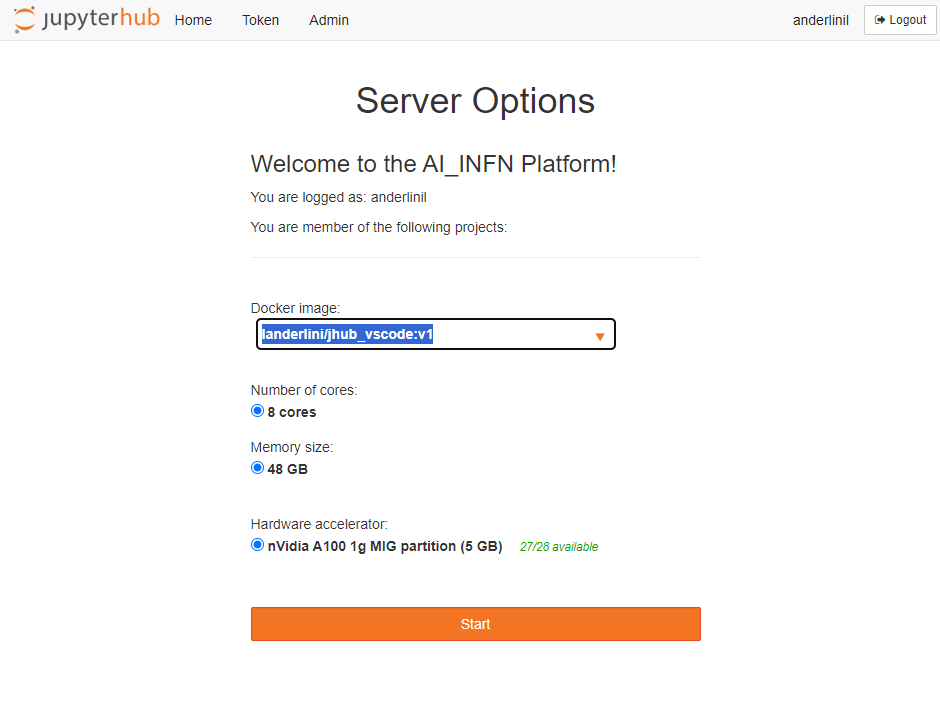

and spawn the new container!

If your image is too large, it may take a bit too long to get pulled from DockerHub and you may get an error like this:

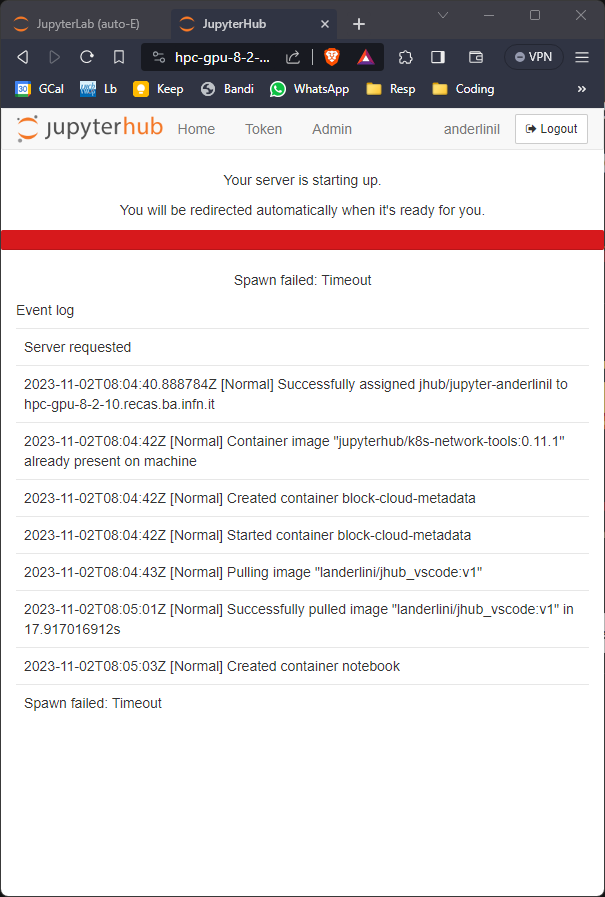

Even if the spawning fails, the image download continues in background. Wait some times for it to complete, and try again.

### Enjoy...
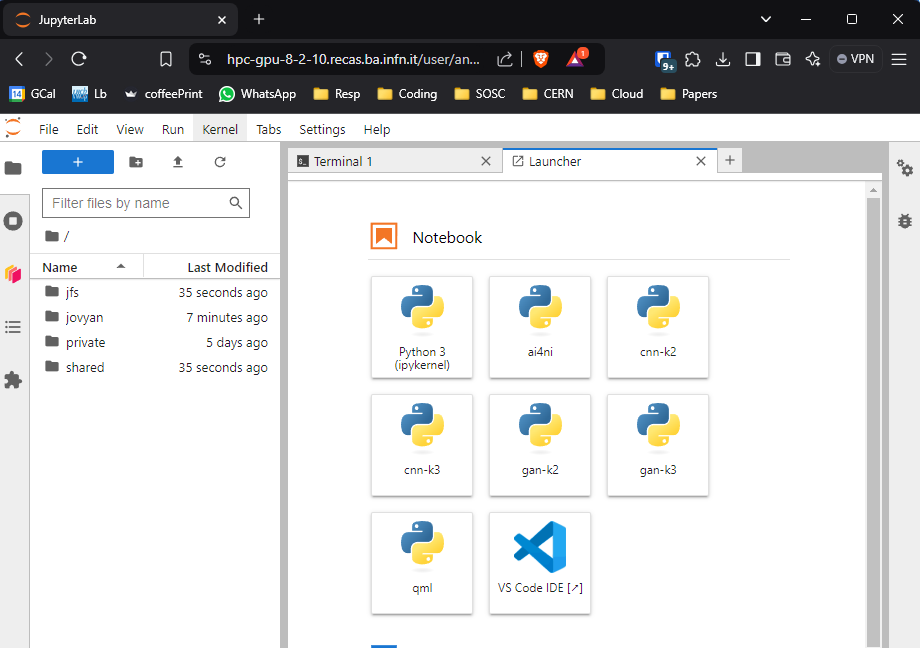

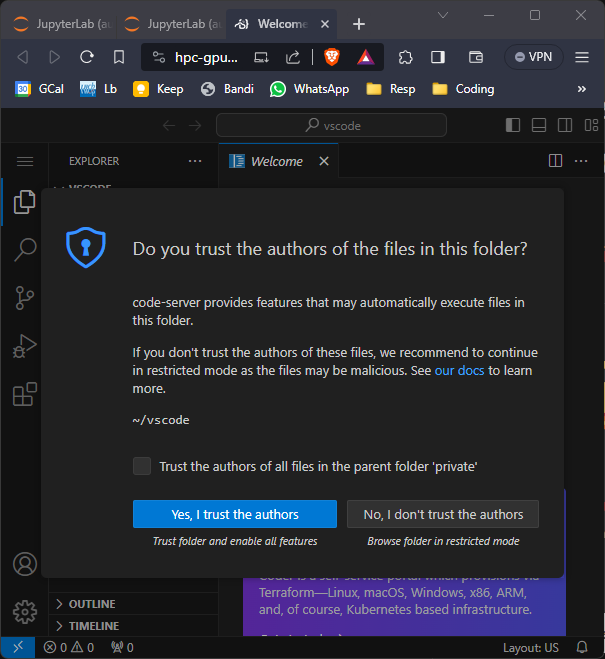


# Conclusion

In this *infrastructure hands-on* we have discussed how to customize the development environment.

In particular, we discussed:
 * how to create custom conda environments in the user space and how to install the kernel in JupyterHub;
 * how to install custom packages in the ephemeral file system of the container (taking podman as an example);
 * how to create a custom Docker image, possibly modifying the configuration of the JupyterLab instance itself, push it on DockerHub and customize the user experience adding third-party web applications.
 
As examples, we have installed TensorBoard, serving it through a Jupyter Proxy and we have installed VS code inside the Docker image.
The approach, however, is much more general, and a vast amount of web-based applications can be run the same way. 

Some notable examples you may want to explore:
 * [pgAdmin4](https://www.pgadmin.org/) a graphical user interface to configure and setup PostgreSQL databases;
 * [OpenRefine](https://openrefine.org/) a dashboard for interactive data visualization and cleaning;
 * [HedgeDoc](https://hedgedoc.org/) a web application for writing notes and documents in markdown;
 * [MLFlow](https://mlflow.org/) a web application with http APIs for tracking machine learning experiments.
 
You can also develop your custom web application, check the [StreamLit project](https://streamlit.io/) to get started.

The customization opportunities are almost endless, but they come with an important limitation you should be aware of:

**All the services and applications you setup within Jupyter are only accessible for a single user, behind an authentication layer, so they are not meant as collaborative tools or services.** 

If you plan to develop a collaborative tool, that has security, maintenance and authentication implications: you are moving out of the AI_INFN domain and entering DataCloud, get in touch and let's discuss how to move forward on a case-by-case basis!